# 1 Бинарная классфикация

## 1 Загрузка бибилиотек

In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import SVG
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import random
import torch

import copy

import albumentations as A
from albumentations import CropNonEmptyMaskIfExists
from typing import List, Optional, Tuple

import time
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

## 2 Загрузка данных

In [3]:
# from google.colab import drive, files
# drive.mount('/content/drive')

In [4]:
# files.upload()

In [5]:
# !ls -lha kaggle.json

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# !chmod 600 /root/.kaggle/kaggle.json

# !kaggle competitions download -c severstal-steel-defect-detection

# !unzip severstal-steel-defect-detection.zip -d /content/dataset >> None

In [6]:
# !cp -r /content/drive/MyDrive/kaggle/severstal/dataset/train_defect_flag.csv /content/dataset
# !cp -r /content/drive/MyDrive/kaggle/severstal/dataset/full_train_df_folds.csv /content/dataset
# !cp -r /content/drive/MyDrive/kaggle/severstal/dataset/train-5-folds.csv /content/dataset
# !cp -r /content/drive/MyDrive/kaggle/severstal/dataset/full_train_df_folds.csv /content/dataset

In [7]:
# !mkdir -p /content/dataset/weights_and_logs

In [8]:
# Тренировочные данные Colab
# train_df = pd.read_csv(os.path.join('/content/drive/MyDrive/kaggle/severstal/dataset/', 'train.csv'))

# Тренировочные данные разбитые по фолдам Colab
# folds_ids = pd.read_csv(os.path.join('/content/drive/MyDrive/kaggle/severstal/dataset/', 'full_train_df_folds.csv'))

# Базовая директория изображений Colab
# BASE_DIR = '/content/drive/MyDrive/kaggle/severstal/dataset/train_images'

In [9]:
import os
notebook_path = os.path.abspath("1-stage-bclass.ipynb")

In [10]:
# Подключим gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # gpu №1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Тренировочные данные
train_df = pd.read_csv(os.path.join(os.path.dirname(notebook_path), 'train.csv'))

# Тренировочные данные разбитые по фолдам
folds_ids = pd.read_csv(os.path.join(os.path.dirname(notebook_path), 'full_train_df_folds.csv'))

In [11]:
# Номер фолда для валидации
NUM_FOLD = 0

In [12]:
# Разделим даннные на тренировочные (4 фолда) и валидационные (1 фолд)
train_files = folds_ids.loc[folds_ids.stratifiedkfold != NUM_FOLD, 'ImageId'].values
valid_files = folds_ids.loc[folds_ids.stratifiedkfold == NUM_FOLD, 'ImageId'].values

train_files.shape, valid_files.shape

((10054,), (2514,))

In [13]:
folds_ids.head()

,ImageId,EncodedPixels_0,EncodedPixels_1,EncodedPixels_2,EncodedPixels_3,EncodedPixels_4,class,stratifiedkfold
0,0002cc93b.jpg,NaN,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1,0
1,00031f466.jpg,0.0,NaN,NaN,NaN,NaN,0,4
2,000418bfc.jpg,0.0,NaN,NaN,NaN,NaN,0,3
3,000789191.jpg,0.0,NaN,NaN,NaN,NaN,0,2
4,0007a71bf.jpg,NaN,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,3,3


## 3 Датасет для тренировочных данных

In [14]:
# Базовая директория изображений
BASE_DIR = os.path.join(os.path.dirname(notebook_path), 'train_images')

# Размер изображения на входе
IN_DIM = (256, 1600)

# Число каналов маски (4 класса)
MASK_CHANELS = 4

In [15]:
# Преобразуем строковые rle (run-length encoding) описания масок в формат изображений
def rle2mask(rle, input_shape):
    # Ширина и высота из входной формы
    width, height = input_shape[:2]

    # Пустой массив для маски
    mask = np.zeros( width*height ).astype(np.uint8)

    # rle стока в массив чисел
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    # Заполненим маски значениями 1 в указанных участках
    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]

    return mask.reshape(height, width).T

# Многослойные маски из списка rle строк
def build_masks(rles, class_ids, input_shape, num_classes):
    masks = np.zeros((*input_shape, num_classes), dtype=np.uint8)

    # Преобразование каждой строки rle в маску и добавление в массив масок
    for rle, class_id in zip(rles, class_ids):
        if isinstance(rle, str):
            masks[:, :, class_id - 1] = rle2mask(rle, input_shape)

    return masks

In [16]:
# Композиция аугментаций изображений
def get_training_augmentation_crop_image():
    train_transform = [

        # Отразим горизонтально / вериткально
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        # Повернем, добавим искажения
        A.Rotate(limit=3, p=0.5),
        A.OpticalDistortion(p=0.2),

        # Выберем одно из следующих действий
        A.OneOf([

            # Кроп, если маска непустая (256x320) или случайный кроп
            # (может кропнуть участок где нет маскированных пикселей)
            CropNonEmptyMaskIfExists(256, 320, p=0.7),
            A.RandomCrop(256, 320, p=0.3),
        ], p=1.0),

        # Дополнение изображения, если необходимо, до размеров (256x320),
        # заполняя границы константным значением 0
        A.PadIfNeeded(min_height=256, min_width=320,
                      border_mode=cv2.BORDER_CONSTANT,
                      value=0, p=0.3),
        #  Случайный кроп (256x320)
        A.RandomCrop(256, 320, p=1.0)
    ]
    return A.Compose(train_transform)

In [17]:
# Нормализуем каждый канал изображения
def get_preprocessing():
    _transform = [
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225))
    ]
    return A.Compose(_transform)

### 3.1 Класс Датасет

In [18]:
# Соберем в класс
class Dataset_train:
    def __init__(
            self,
            ids,
            df,
            images_dir=BASE_DIR,
            dim=IN_DIM,
            augmentation=None,
            preprocessing=None
    ):

        """
        Класс для загрузки обучающего набора данных.

        :param ids: Список имен изображений.
        :param df: DataFrame, с информацией о масках.
        :param images_dir: Директория с изображениями.
        :param dim: Размер входного изображения.
        :param augmentation: Объект аугментации изображения (по умолчанию None).
        :param preprocessing: Объект предварительной обработки изображения (по умолчанию None).
        """

        self.ids = ids
        self.df=df
        self.images_path = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.dim=dim
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        """
        Возвращает один элемент набора данных.

        :param i: Индекс элемента.
        :return: Кортеж из изображения и маски в формате тензоров.
        """
        # Прочитаем изображение
        image = cv2.imread(self.images_path[i], -1)

        # Построим маску
        mask_df = self.df[self.df['ImageId'] == self.ids[i]]
        rles = mask_df['EncodedPixels'].values
        class_ids = mask_df['ClassId'].values
        mask = build_masks(rles, class_ids, input_shape=self.dim, num_classes=MASK_CHANELS)
        mask = np.asarray(mask, np.uint8)

        # Добавим аугментацию
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Добавим препроцессинг
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']

        # Возвращаем изображение и информацию о присутствии классов
        return torch.Tensor(image).permute(2, 0, 1), torch.Tensor(np.max(np.max(mask, axis=(0, 1)), axis=0, keepdims=True))

    def __len__(self):
        """
        Возвращает количество элементов в наборе данных.

        :return: Количество элементов.
        """
        return len(self.ids)

In [19]:
train_dataset = Dataset_train(
        ids=train_files,
        df=train_df,
        augmentation=get_training_augmentation_crop_image(),
        preprocessing=get_preprocessing()
)

In [20]:
next(iter(train_dataset))

(tensor([[[-0.7137, -0.7308, -0.7993,  ..., -0.7479, -0.6965, -0.6452],
          [-0.7650, -0.7822, -0.8507,  ..., -0.7137, -0.7308, -0.6281],
          [-0.8507, -0.8849, -0.9705,  ..., -0.6452, -0.7137, -0.6452],
          ...,
          [-0.0801, -0.0972, -0.1486,  ...,  0.0398,  0.0741,  0.0741],
          [-0.0972, -0.1143, -0.1143,  ...,  0.0398,  0.0741,  0.0741],
          [-0.1314, -0.1486, -0.1314,  ...,  0.0741,  0.0569,  0.1083]],
 
         [[-0.6001, -0.6176, -0.6877,  ..., -0.6352, -0.5826, -0.5301],
          [-0.6527, -0.6702, -0.7402,  ..., -0.6001, -0.6176, -0.5126],
          [-0.7402, -0.7752, -0.8627,  ..., -0.5301, -0.6001, -0.5301],
          ...,
          [ 0.0476,  0.0301, -0.0224,  ...,  0.1702,  0.2052,  0.2052],
          [ 0.0301,  0.0126,  0.0126,  ...,  0.1702,  0.2052,  0.2052],
          [-0.0049, -0.0224, -0.0049,  ...,  0.2052,  0.1877,  0.2402]],
 
         [[-0.3753, -0.3927, -0.4624,  ..., -0.4101, -0.3578, -0.3055],
          [-0.4275, -0.4450,

## 4 Датасет для валидационных данных

In [21]:
# Число участков
N_CROP = 5

# Размер участка
OUT_DIM = (N_CROP, 256, 320)

# Число входных каналов (RGB)
IMG_CHANELS = 3

In [22]:
class Dataset_valid(Dataset):
    def __init__(self,
                 ids,
                 df,
                 images_dir=BASE_DIR,
                 dim=IN_DIM,
                 preprocessing=None):
        """
        Класс для загрузки валидационного набора данных.

        :param ids: Список имен изображений.
        :param df: DataFrame, с информацией о масках.
        :param images_dir: Директория с изображениями.
        :param dim: Размер входного изображения.
        :param preprocessing: Объект предварительной обработки изображения (по умолчанию None).
        """
        self.ids = ids
        self.df = df
        self.images_path = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.dim = dim
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        """
        Возвращает нарезанное изображение и маски на участки.

        Args:
            i (int): Индекс изображения.

        Returns:
            torch.Tensor: Нарезанное изображение на учвастки.
            torch.Tensor: Нарезанная маска на участки с 4-мя слоями на каждом.
        """
        # Чтение данных
        image = cv2.imread(self.images_path[i], -1)

        # Создание маски
        mask_df = self.df[self.df['ImageId'] == self.ids[i]]
        rles = mask_df['EncodedPixels'].values
        class_ids = mask_df['ClassId'].values
        mask = build_masks(rles, class_ids, input_shape=self.dim, num_classes=MASK_CHANELS)

        # Пустые массивы для хранения обрезков
        image_crop = np.empty((*OUT_DIM, IMG_CHANELS))
        mask_crop = np.empty((*OUT_DIM, MASK_CHANELS))

        # Выполнение обрезки
        for i in range(N_CROP):
            image_crop[i] = image[:, i * OUT_DIM[2] : (i + 1) * OUT_DIM[2], :]
            mask_crop[i] = mask[:, i * OUT_DIM[2] : (i + 1) * OUT_DIM[2], :]

        # Применение препроцессинга
        if self.preprocessing:
            sample = self.preprocessing(image=image_crop, mask=mask_crop)
            image_crop, mask_crop = sample['image'], sample['mask']

        # Преобразование в тензоры
        image_crop = torch.Tensor(image_crop).permute(0, 3, 1, 2)
        mask_crop = torch.Tensor(np.max(np.max(mask_crop, axis=(1, 2)), axis=1,  keepdims=True))

        return image_crop, mask_crop

    def __len__(self):
        """
        Возвращает количество изображений в датасете.

        Returns:
            int: Количество изображений.
        """
        return len(self.ids)

In [23]:
valid_dataset = Dataset_valid(
    ids=valid_files,
    df=train_df,
    preprocessing=get_preprocessing()
)

In [24]:
next(iter(valid_dataset))

(tensor([[[[-0.9192, -0.9192, -0.9534,  ..., -1.1418, -0.9020, -0.8164],
           [-0.9877, -0.9534, -0.9534,  ..., -0.9020, -0.7993, -0.6794],
           [-1.0733, -1.0219, -1.0048,  ..., -0.9705, -0.8849, -0.7822],
           ...,
           [ 0.5364,  0.1597,  0.1254,  ..., -0.2171,  0.0056, -0.2513],
           [ 0.6221, -0.2171, -0.4054,  ..., -0.4054, -0.3369, -0.0629],
           [ 0.5364, -0.1657, -0.4397,  ..., -0.3541, -0.2171, -0.0629]],
 
          [[-0.8102, -0.8102, -0.8452,  ..., -1.0378, -0.7927, -0.7052],
           [-0.8803, -0.8452, -0.8452,  ..., -0.7927, -0.6877, -0.5651],
           [-0.9678, -0.9153, -0.8978,  ..., -0.8627, -0.7752, -0.6702],
           ...,
           [ 0.6779,  0.2927,  0.2577,  ..., -0.0924,  0.1352, -0.1275],
           [ 0.7654, -0.0924, -0.2850,  ..., -0.2850, -0.2150,  0.0651],
           [ 0.6779, -0.0399, -0.3200,  ..., -0.2325, -0.0924,  0.0651]],
 
          [[-0.5844, -0.5844, -0.6193,  ..., -0.8110, -0.5670, -0.4798],
           [-

## 5 Даталоадер

In [25]:
BATCH_SIZE = 16

In [26]:
dataloaders = {'train': torch.utils.data.DataLoader(train_dataset,
                                                    shuffle=True,
                                                    num_workers=0,
                                                    batch_size=BATCH_SIZE,
                                                    pin_memory=True),
               'val': torch.utils.data.DataLoader(valid_dataset,
                                                  shuffle=False,
                                                  num_workers=0,
                                                  batch_size=1,
                                                  pin_memory=True)}

In [27]:
%%time
next(iter(dataloaders['train']))[1]

CPU times: total: 172 ms
Wall time: 298 ms


tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [28]:
%%time
next(iter(dataloaders['val']))[1]

CPU times: total: 15.6 ms
Wall time: 35.1 ms


tensor([[[1.],
         [1.],
         [1.],
         [0.],
         [0.]]])

In [29]:
# Размер тренировочного и валидационного датасета
dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)*5}

dataset_sizes

{'train': 10054, 'val': 12570}

## 6 Модель

In [30]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.effnet = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b0', pretrained=True)
        self.effnet.fc = torch.nn.Sequential()
        self.bn0 = torch.nn.BatchNorm1d(num_features=1000)
        self.fc1 = torch.nn.Linear(1000, 512)
        self.act1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(num_features=512)
        self.fc2 = torch.nn.Linear(512, 1)
        self.act2 = torch.nn.Sigmoid()
        
    
    def forward(self, x):
        x = self.effnet(x)
        x = self.bn0(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        
        return x

In [31]:
model = Net()
model = model.to(device)

Using cache found in C:\Users\Admin/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [32]:
# # Fine-tuning
# # Заморозим веса модели (градиенты вычисляться не будут)
# # Для обучения только головы сетки
# for param in model.parameters():
#     param.requires_grad = False

# # # Проверка
# # for param in model.parameters():
# #     print(param.requires_grad)  # Все параметры должны быть False

# # Разморозим последние слои
# for param in model.fc1.parameters():
#     param.requires_grad = True
# for param in model.bn1.parameters():
#     param.requires_grad = True
# for param in model.fc2.parameters():
#     param.requires_grad = True

# # Проверка, что параметры новых слоев не заморожены
# for param in model.fc1.parameters():
#     print(param.requires_grad)  # Все параметры должны быть True
# for param in model.bn1.parameters():
#     print(param.requires_grad)  # Все параметры должны быть True
# for param in model.fc2.parameters():
#     print(param.requires_grad)  # Все параметры должны быть True

## 7 Метрики

In [33]:
def get_metrics(true, pred):
    true = true.flatten()
    pred = pred.flatten()
    
    val_f1, val_precision, val_recall, val_acc = 0, 0, 0, 0

    val_f1 = round(f1_score(true, pred, zero_division=0), 3)
    val_precision = round(precision_score(true, pred, zero_division=0), 3)
    val_recall = round(recall_score(true, pred, zero_division=0), 3)
    val_acc = round(accuracy_score(true, pred), 3)

    print('f1: {}, \npresicion: {}, \nrecall: {}, \nacc: {}'.format(
          val_f1, val_precision, val_recall, val_acc), end=' ')
    return val_f1

## 8 Обучение

In [34]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes,
                scheduler, device, num_epochs=25, early_stop_patience=15):
    # Временная отметка
    since = time.time()

    # Глубокая копия весов модели
    best_model_wts = copy.deepcopy(model.state_dict())

    # Переменная лучшей метрики
    best_metrics = 0.0

    # Счетчик ранней остановки
    early_stoping = 0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Переведем модель в режим обучения
        model.train()
        running_loss = 0.0

        # Обучение
        # Число батчей для обучения
        num_batches_to_process_test = 5 #dataloaders['train'].__len__()
        
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            if i >= num_batches_to_process_test:
                break
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Обнулим градиенты
            optimizer.zero_grad()

            # Режим отслеживания градиентов для последующего бэкпропа
            with torch.set_grad_enabled(True):
                outputs = model(inputs)

                # Бинаризируем по порогу 0.5
                preds = (outputs > 0.5).long()

                # Вычислим среднюю потерю BCELoss по батчу
                loss = criterion(outputs, labels)

                # Вычислим градиенты ф. п. ко всем параметрам модели (backprop)
                loss.backward()

                # Обновим параметры модели на основе вычисленных градиентов
                optimizer.step()

            # Вычислим общую потерю батча и добавим к потерям всех батчей
            running_loss += loss.item() * inputs.size(0)

        # Средняя потеря на один объект (изображение)
        epoch_loss_train = running_loss / dataset_sizes['train']

        # Валидация
        model.eval()

        running_loss = 0.0

        pred, true = [], []

        # Число батчей для валидации
        num_batches_to_process_val = 5 #dataloaders['val'].__len__()
        
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            if i >= num_batches_to_process_val:
                break
            inputs = inputs[0].to(device)
            labels = labels[0].to(device)

            # Прогнозы для участка и его каждого класса без подсчета градиента
            with torch.no_grad():
                outputs = model(inputs)

                # Бинаризируем порог по границе 0.5
                preds = (outputs > 0.5).long()

                # Вычислим среднюю потерю BCELoss по батчу (по 5 участкам изображения)
                loss = criterion(outputs, labels)

            # Вычислим общую потерю батча и добавим к потерям всех батчей
            running_loss += loss.item() * inputs.size(0)

            # Сохраним предсказания и истинные метки в список
            true.extend(labels.data.cpu().numpy())
            pred.extend(preds.data.cpu().numpy())

        # Средняя потеря на один объект (изображение)
        epoch_loss_val = running_loss / dataset_sizes['val']

        # Выведем потери на одно изображение для трейна и валидации
        print('train loss: {:.4f} val loss: {:.4f}'.format(epoch_loss_train, epoch_loss_val))

        # Предсказания и действительные метки
        pred = np.array(pred)
        true = np.array(true)

        # Посчитаем основные метрики
        metrics_val = get_metrics(true, pred)

        # Будем сохранять каждую эпоху веса модели если метрика лучше предыдущей
        if metrics_val > best_metrics:
            print('*')
            best_metrics = metrics_val # Смотрим по f1

            # Делаем глубокое копирование словаря с парметрами модели
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, PATH_WEIGTS)
            early_stoping = 0
        else:
            print('-')
            # Если модель не улучшает скор на эпохе то знач. счетчика += 1
            early_stoping += 1

        # Условие ранней остановки
        if early_stoping > early_stop_patience:
            break

        # Шаг шедуллера для отслеживания метрики см. EARLY_STOP_PATIENCE
        scheduler.step(metrics_val)

        # Запишем логи
        with open('./weights_and_logs/1-stage-bclass-logs4.txt','a') as f:
            f.write('''train_loss: {:.4f} val_loss: {:.4f} val_metrics: {:.4f}\n'''.format(epoch_loss_train,
                                                                                           epoch_loss_val,
                                                                                           metrics_val))
    # Подсчитаем время выполнения
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val metrics: {:4f}'.format(best_metrics))

    # Загрузим веса лучшей модели
    model.load_state_dict(best_model_wts)
    return model

## 9 Параметры обучения

In [35]:
# Путь логов для сохранения модели 
file_weigts_name = '1-stage-bclass-model_fold_%d.h5'%NUM_FOLD
PATH_WEIGTS = os.path.join(os.path.join(os.path.dirname(notebook_path), 'weights_and_logs'),  file_weigts_name)


# Определим основные параметры обучения
LR = 4e-4
REDUCE_LR_FACTOR = 0.25
REDUCE_LR_PATIENCE = 7
REDUCE_LR_MIN = 1e-6

criterion = torch.nn.BCELoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max',
                                                                  factor=REDUCE_LR_FACTOR,
                                                                  patience=REDUCE_LR_PATIENCE,
                                                                  min_lr=REDUCE_LR_MIN
                                                                    )

## 10 Запуск обучения

In [278]:
EPOCHS = 100
EARLY_STOP_PATIENCE = 15

model = train_model(model, criterion, optimizer_ft, dataloaders,
                        dataset_sizes, lr_scheduler, device,
                        num_epochs=EPOCHS, early_stop_patience=EARLY_STOP_PATIENCE)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
----------


  1%|          | 1/100 [05:26<8:59:05, 326.72s/it]

train loss: 0.3099 val loss: 0.2047
f1: 0.831, 
presicion: 0.82, 
recall: 0.843, 
acc: 0.92 *
Epoch 1/99
----------


  2%|▏         | 2/100 [10:54<8:54:12, 327.06s/it]

train loss: 0.2606 val loss: 0.2152
f1: 0.834, 
presicion: 0.823, 
recall: 0.845, 
acc: 0.921 *
Epoch 2/99
----------


  3%|▎         | 3/100 [16:21<8:49:20, 327.43s/it]

train loss: 0.2439 val loss: 0.2118
f1: 0.852, 
presicion: 0.818, 
recall: 0.89, 
acc: 0.927 *
Epoch 3/99
----------


  4%|▍         | 4/100 [21:49<8:44:02, 327.53s/it]

train loss: 0.2293 val loss: 0.1985
f1: 0.843, 
presicion: 0.791, 
recall: 0.902, 
acc: 0.921 -
Epoch 4/99
----------


  5%|▌         | 5/100 [27:16<8:38:27, 327.44s/it]

train loss: 0.2194 val loss: 0.1856
f1: 0.859, 
presicion: 0.838, 
recall: 0.88, 
acc: 0.932 *
Epoch 5/99
----------


  6%|▌         | 6/100 [32:33<8:27:23, 323.86s/it]

train loss: 0.2185 val loss: 0.1648
f1: 0.871, 
presicion: 0.875, 
recall: 0.866, 
acc: 0.939 *
Epoch 6/99
----------


  7%|▋         | 7/100 [38:02<8:24:22, 325.40s/it]

train loss: 0.1923 val loss: 0.1758
f1: 0.858, 
presicion: 0.881, 
recall: 0.836, 
acc: 0.935 -
Epoch 7/99
----------


  8%|▊         | 8/100 [43:29<8:19:48, 325.97s/it]

train loss: 0.2022 val loss: 0.1657
f1: 0.875, 
presicion: 0.884, 
recall: 0.866, 
acc: 0.942 *
Epoch 8/99
----------


  9%|▉         | 9/100 [48:55<8:14:26, 326.00s/it]

train loss: 0.1857 val loss: 0.1971
f1: 0.855, 
presicion: 0.906, 
recall: 0.81, 
acc: 0.935 -
Epoch 9/99
----------


 10%|█         | 10/100 [54:21<8:08:52, 325.92s/it]

train loss: 0.1829 val loss: 0.1728
f1: 0.871, 
presicion: 0.884, 
recall: 0.858, 
acc: 0.94 -
Epoch 10/99
----------


 11%|█         | 11/100 [59:47<8:03:42, 326.09s/it]

train loss: 0.1835 val loss: 0.1617
f1: 0.87, 
presicion: 0.869, 
recall: 0.87, 
acc: 0.939 -
Epoch 11/99
----------


 12%|█▏        | 12/100 [1:05:14<7:58:33, 326.29s/it]

train loss: 0.1834 val loss: 0.1600
f1: 0.871, 
presicion: 0.853, 
recall: 0.89, 
acc: 0.938 -
Epoch 12/99
----------


 13%|█▎        | 13/100 [1:10:40<7:52:49, 326.09s/it]

train loss: 0.1797 val loss: 0.1574
f1: 0.873, 
presicion: 0.873, 
recall: 0.873, 
acc: 0.94 -
Epoch 13/99
----------


 14%|█▍        | 14/100 [1:16:05<7:47:08, 325.91s/it]

train loss: 0.1757 val loss: 0.1522
f1: 0.874, 
presicion: 0.864, 
recall: 0.884, 
acc: 0.94 -
Epoch 14/99
----------


 15%|█▌        | 15/100 [1:21:32<7:41:57, 326.09s/it]

train loss: 0.1767 val loss: 0.1509
f1: 0.877, 
presicion: 0.86, 
recall: 0.895, 
acc: 0.941 *
Epoch 15/99
----------


 16%|█▌        | 16/100 [1:26:58<7:36:27, 326.04s/it]

train loss: 0.1759 val loss: 0.1704
f1: 0.866, 
presicion: 0.852, 
recall: 0.88, 
acc: 0.936 -
Epoch 16/99
----------


 17%|█▋        | 17/100 [1:32:24<7:31:05, 326.10s/it]

train loss: 0.1702 val loss: 0.1610
f1: 0.869, 
presicion: 0.846, 
recall: 0.894, 
acc: 0.937 -
Epoch 17/99
----------


 18%|█▊        | 18/100 [1:37:50<7:25:41, 326.11s/it]

train loss: 0.1631 val loss: 0.1625
f1: 0.868, 
presicion: 0.86, 
recall: 0.877, 
acc: 0.937 -
Epoch 18/99
----------
train loss: 0.1664 val loss: 0.1546
f1: 0.878, 
presicion: 0.868, 
recall: 0.888, 
acc: 0.942 *


 19%|█▉        | 19/100 [1:43:16<7:20:15, 326.12s/it]

Epoch 19/99
----------


 20%|██        | 20/100 [1:48:43<7:15:11, 326.39s/it]

train loss: 0.1606 val loss: 0.1684
f1: 0.871, 
presicion: 0.829, 
recall: 0.917, 
acc: 0.936 -
Epoch 20/99
----------


 21%|██        | 21/100 [1:54:10<7:10:02, 326.61s/it]

train loss: 0.1667 val loss: 0.1471
f1: 0.883, 
presicion: 0.898, 
recall: 0.87, 
acc: 0.946 *
Epoch 21/99
----------


 22%|██▏       | 22/100 [1:59:37<7:04:45, 326.74s/it]

train loss: 0.1655 val loss: 0.1450
f1: 0.883, 
presicion: 0.88, 
recall: 0.886, 
acc: 0.945 -
Epoch 22/99
----------


 23%|██▎       | 23/100 [2:05:04<6:59:08, 326.60s/it]

train loss: 0.1610 val loss: 0.1498
f1: 0.878, 
presicion: 0.867, 
recall: 0.89, 
acc: 0.942 -
Epoch 23/99
----------


 24%|██▍       | 24/100 [2:10:30<6:53:39, 326.58s/it]

train loss: 0.1385 val loss: 0.1484
f1: 0.876, 
presicion: 0.881, 
recall: 0.871, 
acc: 0.942 -
Epoch 24/99
----------


 25%|██▌       | 25/100 [2:15:57<6:48:10, 326.54s/it]

train loss: 0.1606 val loss: 0.1456
f1: 0.879, 
presicion: 0.846, 
recall: 0.915, 
acc: 0.941 -
Epoch 25/99
----------


 26%|██▌       | 26/100 [2:21:24<6:42:53, 326.67s/it]

train loss: 0.1510 val loss: 0.1646
f1: 0.866, 
presicion: 0.827, 
recall: 0.908, 
acc: 0.934 -
Epoch 26/99
----------


 27%|██▋       | 27/100 [2:26:51<6:37:54, 327.04s/it]

train loss: 0.1666 val loss: 0.1452
f1: 0.882, 
presicion: 0.88, 
recall: 0.884, 
acc: 0.944 -
Epoch 27/99
----------


 28%|██▊       | 28/100 [2:32:20<6:33:06, 327.58s/it]

train loss: 0.1494 val loss: 0.1679
f1: 0.864, 
presicion: 0.851, 
recall: 0.877, 
acc: 0.935 -
Epoch 28/99
----------


 29%|██▉       | 29/100 [2:37:50<6:28:33, 328.36s/it]

train loss: 0.1562 val loss: 0.1442
f1: 0.88, 
presicion: 0.891, 
recall: 0.871, 
acc: 0.944 -
Epoch 29/99
----------


 30%|███       | 30/100 [2:43:17<6:22:32, 327.89s/it]

train loss: 0.1286 val loss: 0.1385
f1: 0.886, 
presicion: 0.879, 
recall: 0.892, 
acc: 0.946 *
Epoch 30/99
----------


 31%|███       | 31/100 [2:48:43<6:16:24, 327.31s/it]

train loss: 0.1197 val loss: 0.1327
f1: 0.894, 
presicion: 0.907, 
recall: 0.882, 
acc: 0.951 *
Epoch 31/99
----------


 32%|███▏      | 32/100 [2:54:11<6:11:02, 327.39s/it]

train loss: 0.1197 val loss: 0.1341
f1: 0.891, 
presicion: 0.874, 
recall: 0.907, 
acc: 0.947 -
Epoch 32/99
----------


 33%|███▎      | 33/100 [2:59:38<6:05:23, 327.21s/it]

train loss: 0.1129 val loss: 0.1313
f1: 0.898, 
presicion: 0.898, 
recall: 0.898, 
acc: 0.952 *
Epoch 33/99
----------


 34%|███▍      | 34/100 [3:05:04<5:59:37, 326.94s/it]

train loss: 0.1125 val loss: 0.1351
f1: 0.894, 
presicion: 0.882, 
recall: 0.906, 
acc: 0.949 -
Epoch 34/99
----------


 35%|███▌      | 35/100 [3:10:30<5:54:00, 326.77s/it]

train loss: 0.1119 val loss: 0.1280
f1: 0.897, 
presicion: 0.9, 
recall: 0.894, 
acc: 0.952 -
Epoch 35/99
----------


 36%|███▌      | 36/100 [3:15:57<5:48:39, 326.87s/it]

train loss: 0.1124 val loss: 0.1319
f1: 0.894, 
presicion: 0.906, 
recall: 0.881, 
acc: 0.951 -
Epoch 36/99
----------


 37%|███▋      | 37/100 [3:21:28<5:44:25, 328.02s/it]

train loss: 0.1105 val loss: 0.1312
f1: 0.895, 
presicion: 0.89, 
recall: 0.9, 
acc: 0.95 -
Epoch 37/99
----------


 38%|███▊      | 38/100 [3:27:01<5:40:35, 329.61s/it]

train loss: 0.1102 val loss: 0.1306
f1: 0.897, 
presicion: 0.89, 
recall: 0.904, 
acc: 0.951 -
Epoch 38/99
----------


 39%|███▉      | 39/100 [3:32:30<5:34:46, 329.29s/it]

train loss: 0.1033 val loss: 0.1259
f1: 0.896, 
presicion: 0.913, 
recall: 0.88, 
acc: 0.952 -
Epoch 39/99
----------


 40%|████      | 40/100 [3:37:57<5:28:38, 328.64s/it]

train loss: 0.1061 val loss: 0.1307
f1: 0.895, 
presicion: 0.901, 
recall: 0.889, 
acc: 0.951 -
Epoch 40/99
----------


 41%|████      | 41/100 [3:43:24<5:22:38, 328.11s/it]

train loss: 0.1180 val loss: 0.1282
f1: 0.897, 
presicion: 0.903, 
recall: 0.89, 
acc: 0.952 -
Epoch 41/99
----------


 42%|████▏     | 42/100 [3:48:51<5:16:47, 327.72s/it]

train loss: 0.1015 val loss: 0.1276
f1: 0.899, 
presicion: 0.904, 
recall: 0.893, 
acc: 0.953 *
Epoch 42/99
----------


 43%|████▎     | 43/100 [3:54:19<5:11:23, 327.77s/it]

train loss: 0.1036 val loss: 0.1245
f1: 0.9, 
presicion: 0.913, 
recall: 0.887, 
acc: 0.954 *
Epoch 43/99
----------


 44%|████▍     | 44/100 [3:59:46<5:05:53, 327.74s/it]

train loss: 0.0955 val loss: 0.1292
f1: 0.901, 
presicion: 0.902, 
recall: 0.901, 
acc: 0.954 *
Epoch 44/99
----------


 45%|████▌     | 45/100 [4:05:13<5:00:16, 327.57s/it]

train loss: 0.1009 val loss: 0.1256
f1: 0.903, 
presicion: 0.907, 
recall: 0.899, 
acc: 0.954 *
Epoch 45/99
----------


 46%|████▌     | 46/100 [4:10:42<4:55:03, 327.84s/it]

train loss: 0.1011 val loss: 0.1283
f1: 0.9, 
presicion: 0.896, 
recall: 0.904, 
acc: 0.953 -
Epoch 46/99
----------


 47%|████▋     | 47/100 [4:16:11<4:49:57, 328.26s/it]

train loss: 0.1046 val loss: 0.1238
f1: 0.902, 
presicion: 0.913, 
recall: 0.892, 
acc: 0.955 -
Epoch 47/99
----------


 48%|████▊     | 48/100 [4:21:39<4:44:16, 328.01s/it]

train loss: 0.1010 val loss: 0.1260
f1: 0.904, 
presicion: 0.911, 
recall: 0.897, 
acc: 0.955 *
Epoch 48/99
----------


 49%|████▉     | 49/100 [4:27:06<4:38:37, 327.79s/it]

train loss: 0.0944 val loss: 0.1288
f1: 0.898, 
presicion: 0.895, 
recall: 0.902, 
acc: 0.952 -
Epoch 49/99
----------


 50%|█████     | 50/100 [4:32:32<4:32:48, 327.36s/it]

train loss: 0.0967 val loss: 0.1291
f1: 0.898, 
presicion: 0.89, 
recall: 0.907, 
acc: 0.952 -
Epoch 50/99
----------


 51%|█████     | 51/100 [4:37:59<4:27:16, 327.28s/it]

train loss: 0.0987 val loss: 0.1274
f1: 0.902, 
presicion: 0.897, 
recall: 0.906, 
acc: 0.954 -
Epoch 51/99
----------


 52%|█████▏    | 52/100 [4:43:26<4:21:40, 327.09s/it]

train loss: 0.0911 val loss: 0.1315
f1: 0.9, 
presicion: 0.884, 
recall: 0.915, 
acc: 0.952 -
Epoch 52/99
----------


 53%|█████▎    | 53/100 [4:48:55<4:16:44, 327.76s/it]

train loss: 0.0925 val loss: 0.1274
f1: 0.899, 
presicion: 0.897, 
recall: 0.901, 
acc: 0.952 -
Epoch 53/99
----------


 54%|█████▍    | 54/100 [4:54:26<4:11:55, 328.60s/it]

train loss: 0.0969 val loss: 0.1251
f1: 0.902, 
presicion: 0.906, 
recall: 0.899, 
acc: 0.954 -
Epoch 54/99
----------


 55%|█████▌    | 55/100 [4:59:54<4:06:24, 328.54s/it]

train loss: 0.0993 val loss: 0.1292
f1: 0.901, 
presicion: 0.894, 
recall: 0.908, 
acc: 0.953 -
Epoch 55/99
----------


 56%|█████▌    | 56/100 [5:05:21<4:00:28, 327.93s/it]

train loss: 0.0969 val loss: 0.1279
f1: 0.901, 
presicion: 0.916, 
recall: 0.886, 
acc: 0.954 -
Epoch 56/99
----------


 57%|█████▋    | 57/100 [5:10:48<3:54:55, 327.80s/it]

train loss: 0.0921 val loss: 0.1300
f1: 0.899, 
presicion: 0.906, 
recall: 0.891, 
acc: 0.953 -
Epoch 57/99
----------


 58%|█████▊    | 58/100 [5:16:14<3:49:04, 327.26s/it]

train loss: 0.0942 val loss: 0.1267
f1: 0.9, 
presicion: 0.908, 
recall: 0.892, 
acc: 0.953 -
Epoch 58/99
----------


 59%|█████▉    | 59/100 [5:21:40<3:43:21, 326.88s/it]

train loss: 0.0909 val loss: 0.1250
f1: 0.902, 
presicion: 0.915, 
recall: 0.889, 
acc: 0.955 -
Epoch 59/99
----------


 60%|██████    | 60/100 [5:27:09<3:38:12, 327.32s/it]

train loss: 0.0975 val loss: 0.1248
f1: 0.901, 
presicion: 0.908, 
recall: 0.894, 
acc: 0.954 -
Epoch 60/99
----------


 61%|██████    | 61/100 [5:32:37<3:33:01, 327.73s/it]

train loss: 0.0975 val loss: 0.1254
f1: 0.902, 
presicion: 0.903, 
recall: 0.901, 
acc: 0.954 -
Epoch 61/99
----------


 62%|██████▏   | 62/100 [5:38:04<3:27:21, 327.42s/it]

train loss: 0.0955 val loss: 0.1252
f1: 0.901, 
presicion: 0.905, 
recall: 0.897, 
acc: 0.954 -
Epoch 62/99
----------


 63%|██████▎   | 63/100 [5:43:30<3:21:36, 326.93s/it]

train loss: 0.0997 val loss: 0.1260
f1: 0.901, 
presicion: 0.911, 
recall: 0.891, 
acc: 0.954 -
Epoch 63/99
----------


 63%|██████▎   | 63/100 [5:48:59<3:24:57, 332.37s/it]

train loss: 0.0892 val loss: 0.1264
f1: 0.901, 
presicion: 0.903, 
recall: 0.899, 
acc: 0.954 -
Training complete in 348m 59s
Best val metrics: 0.904000


## 11 Результаты

In [49]:
with open(os.path.join(os.path.join(os.path.dirname(notebook_path), 'weights_and_logs'),  '1-stage-bclass-logs4.txt'),'r') as f:
    logs = f.read()

logs = logs.split('\n')

metrics_4 = [float(x.split(' ')[-1]) for x in logs[:-1]]
train_loss_4 = [float(x.split(' ')[1]) for x in logs[:-1]]
val_loss_4 = [float(x.split(' ')[3]) for x in logs[:-1]]

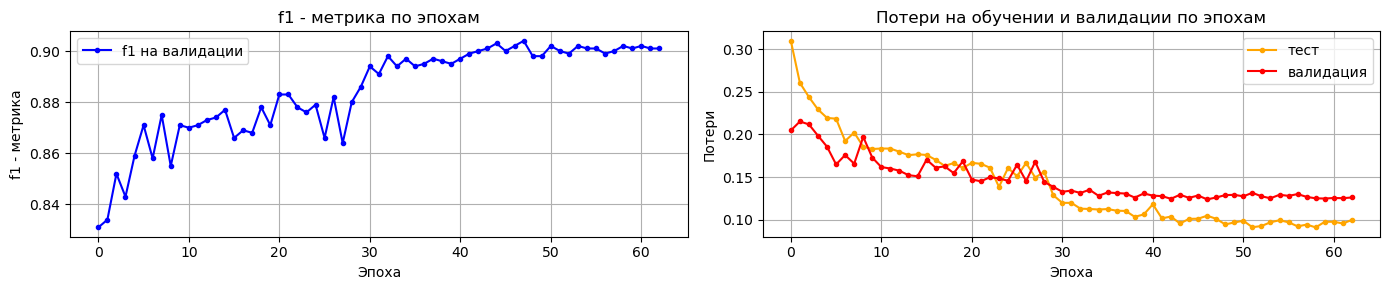

In [50]:
# Визуализация потерь и f1 - метрики
plt.figure(figsize=(14, 3))

# График f1 - метрики
plt.subplot(1, 2, 1)
plt.plot(metrics_4, '.-', label='f1 на валидации', color='blue')
plt.xlabel('Эпоха')
plt.ylabel('f1 - метрика')
plt.title('f1 - метрика по эпохам')
plt.legend()
plt.grid(True)

# График потерь
plt.subplot(1, 2, 2)
plt.plot(train_loss_4, '.-', label='тест', color='orange')
plt.plot(val_loss_4, '.-', label='валидация', color='red')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на обучении и валидации по эпохам')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

__`efficientnet_b0` по f1 на валидации 48 эпохи: `0.904`. Модель предсказывала наличие или отсутствия дефекта на изображении.__

~**1 (проверить) 25 - 30 эпоха: вероятно сработал шедуллер, и за счет снижения шага обучения модель вышла из локального минимума**~

~**2 (проверить) попробовать другой фолд для валидации**~

EPOCHS = 100

EARLY_STOP_PATIENCE = 15

BCELoss(),

Adam(4e-4),

ReduceLROnPlateau(REDUCE_LR_FACTOR = 0.25, REDUCE_LR_PATIENCE = 7, REDUCE_LR_MIN = 1e-6)